# Quick guide for hub_tools.py

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from hub_tools import *

## Displaying images from FITS files

Use the $\tt{display_-fits(file)}$ function to open any FITS file containing a data array in the first HDU list object.

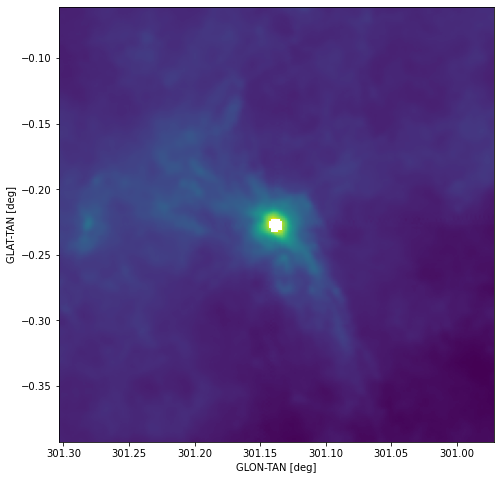

In [2]:
file = 'example.fits'
display_fits(file)

## Changing the displayed area

You can display a narrower window by passing the $\tt{lims}$ argument to $\tt{display_{---}fits(file,lims=[xl,xr,yb,yt])}$.

This argument should be a list specifying the left, right, lower and upper limits (in that order) in longitude and latitude units from the FITS file.


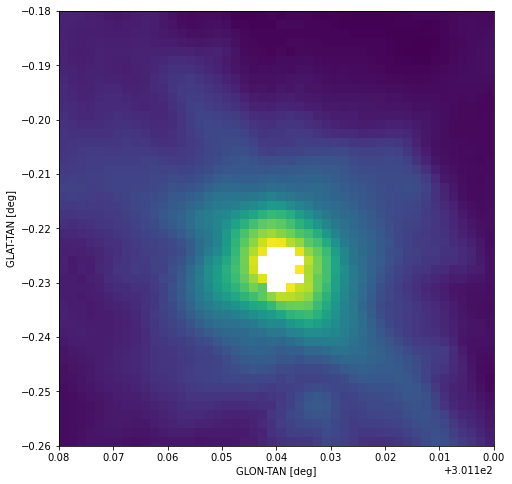

In [3]:
x_left = 301.18
x_right = 301.10
y_bottom = -0.26
y_top = -0.18

limits = [x_left,x_right,y_bottom,y_top]

display_fits(file,lims=limits)

## Returning the subset of data limited by the new window

If you want to use this smaller dataset, you can retrieve the narrowed down array by setting the $\tt{return_-vals}$ argument to $\tt{True}$.

In that case, besides showing the heatmap, $\tt{display_{---}fits()}$ will return 3 objects:

1. a numpy.meshgrid() of (lon,lat) values at every point,

2. an array with the data values at the corresponding points and

3. a boolean array specifying whether the corresponding pixel is saturated or not.

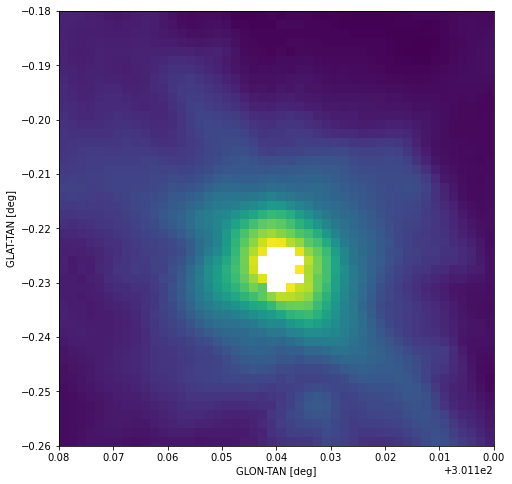

<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'> 

Longitude grid: 
 [[301.17844978 301.17678312 301.17511645 ... 301.10344978 301.10178312
  301.10011645]
 [301.17844978 301.17678312 301.17511645 ... 301.10344978 301.10178312
  301.10011645]
 [301.17844978 301.17678312 301.17511645 ... 301.10344978 301.10178312
  301.10011645]
 ...
 [301.17844978 301.17678312 301.17511645 ... 301.10344978 301.10178312
  301.10011645]
 [301.17844978 301.17678312 301.17511645 ... 301.10344978 301.10178312
  301.10011645]
 [301.17844978 301.17678312 301.17511645 ... 301.10344978 301.10178312
  301.10011645]] 

Latitude grid: 
 [[-0.25927402 -0.25927402 -0.25927402 ... -0.25927402 -0.25927402
  -0.25927402]
 [-0.25760735 -0.25760735 -0.25760735 ... -0.25760735 -0.25760735
  -0.25760735]
 [-0.25594069 -0.25594069 -0.25594069 ... -0.25594069 -0.25594069
  -0.25594069]
 ...
 [-0.18427402 -0.18427402 -0.18427402 ... -0.18427402 -0.18427402
  -0.18427402]
 [-0.18260735 -0.18260735 -0.18260735 ...

In [4]:
grid,data,sat = display_fits(file,lims=limits,return_vals=True)
print(type(grid))
print(type(data))
print(type(sat),'\n')

print('Longitude grid:','\n',grid[0],'\n')
print('Latitude grid:','\n',grid[1],'\n')
print('Data:','\n',data,'\n')
print('Saturated pixel:','\n',sat)

## Gaussian fitting of saturated data
Now, to fix a saturated image, we may use the $\tt{fitter()}$ function.

At least 3 arguments should be passed: $\tt{grid}$, $\tt{data}$ and $\tt{sat}$. These should be the same types of objects as those returned by $\tt{display_{---}fits()}$ with $\tt{return_{---}vals} = True$, which were described above.

The function returns 2 objects:

1. a 1D array type of object containing all the parameters of the gaussian fit,


2. a 2D array with the corrected image.

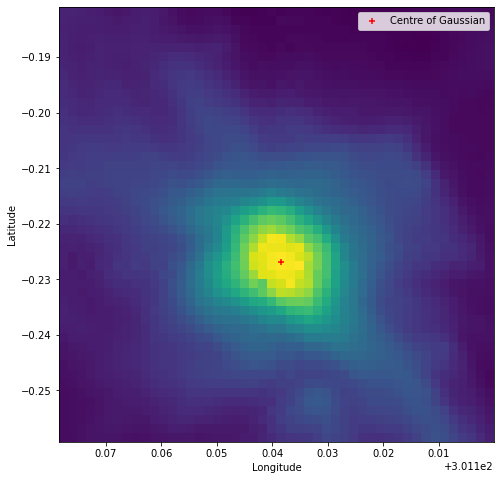

Position of the peak: (301.1384277233264, -0.22692427803417353)

Height of the peak: 37425.769310083524

Angle of the Ellipse: 0.7917633669386684

FWHM of axis': (0.011355322384998109, 0.014100312307211484)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [11]:
#Using arguments from previous cell
params,image = fitter(grid,data,sat) 

#Defining X,Y to set the scale on the plt.imshow()
X,Y = grid

plt.figure(figsize=(8,8))
plt.imshow(np.log10(image),origin='lower',extent=(X.max(),X.min(),Y.min(),Y.max()))
plt.scatter(params[0],params[1],marker='+',color='r',label='Centre of Gaussian')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

#Getting the parameters of the fit
mu_x,mu_y,N,theta,FWHM_x,FWHM_y = params
print("Position of the peak: ({i}, {j})\n".format(i = mu_x, j = mu_y))
print("Height of the peak: {i}\n".format(i = N))
print("Angle of the Ellipse: {i}\n".format(i = theta))
print("FWHM of axis': ({i}, {j})".format(i = FWHM_x, j = FWHM_y))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

So far, we haven't given the programme any initial guesses for the shape and position of the gaussian surface we are trying to fit. In this case the fit was ok, but in many others this won't be enough and we should provide information, especially about the FWHM values.

The $\tt{fitter()}$ function can be used to fit multiple peaks within the same image, therefore, if we want to use the non-default option of giving the FWHM values, we have to supply 2 (amax,amin) values for each peak.

So the FWHM input is a numpy array with the shape of the following matrix:

$$FWHM = \begin{bmatrix} a_{max}^{(1)} & a_{min}^{(1)} \\ a_{max}^{(2)} & a_{min}^{(2)} \\ \vdots & \vdots \\ a_{max}^{(n)} & a_{min}^{(n)} \end{bmatrix}$$

where, $a_\mathrm{max}^{(i)}$ is the FWHM value for the $i$-th peak along the semi-major axis.

Note: if we try to fit $n$ peaks, that information should be included in the ${\tt peaks} = n$ argument, which has a default of 1.

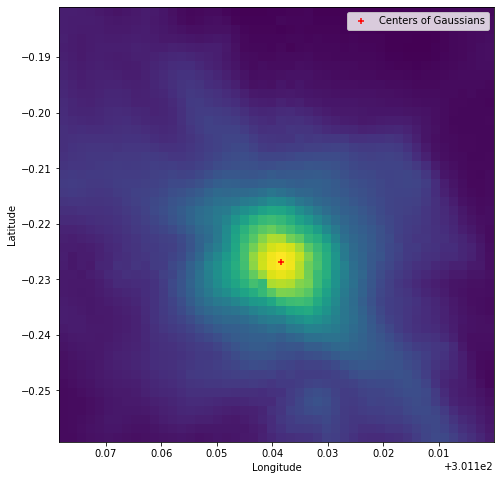

[ 3.01138504e+02 -2.26937631e-01  6.44861017e+04  3.14159265e+00
  9.02777778e-03  9.02777778e-03]


In [6]:
#supplying FWHM values to the fitter (in arcsec)
#Note how FWHM_vals has 2 sets of brackets [[]], even for 1 peak.

FWHM_vals = np.array([[32.,32.]])

params,image = fitter(grid,data,sat,FWHM=FWHM_vals)

plt.figure(figsize=(8,8))
plt.imshow(np.log10(image),origin='lower',extent=(X.max(),X.min(),Y.min(),Y.max()))
plt.scatter(params[0::6],params[1::6],marker='+',color='r',label='Centers of Gaussians')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

print(params)

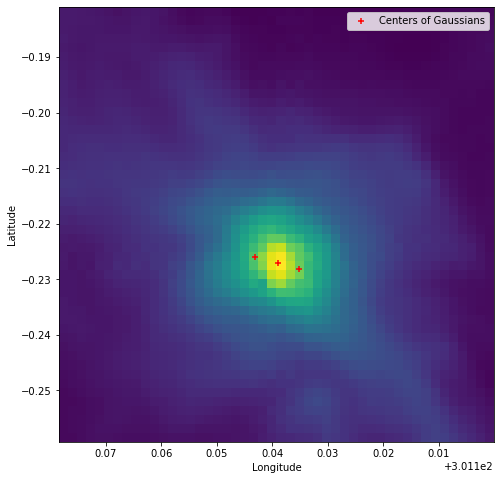

In [7]:
#Doing the same with 3 peaks, supplying 3 pairs of FWHM values (in arcsec)

FWHM_vals = np.array([[18.,16.],
                 [12.,24.],
                 [22.,22.]])
n = 3

params,image = fitter(grid,data,sat,peaks=n,FWHM=FWHM_vals)

plt.figure(figsize=(8,8))
plt.imshow(np.log10(image),origin='lower',extent=(X.max(),X.min(),Y.min(),Y.max()))
plt.scatter(params[0::6],params[1::6],marker='+',color='r',label='Centers of Gaussians')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

By default, the FWHM units should be provided in arcsec, but can also be in degrees, in which case the argument $\tt{units_{---}FWHM = ""}$ must be specified. Anything can be provided in the "", as long as it's different from "arcsec".

The same applies for the argument $\tt{theta}$, by default in degrees.

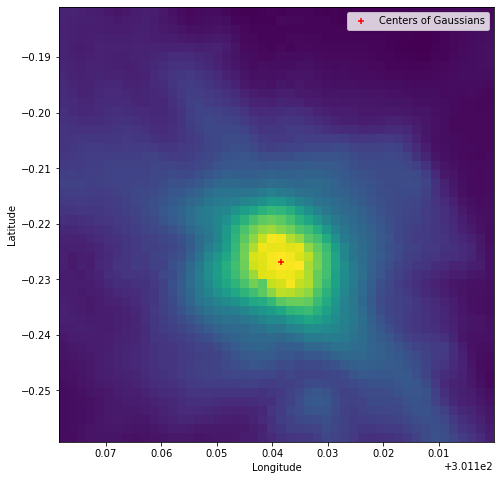

In [8]:
#supplying FWHM values to the fitter (in degrees)

FWHM_vals = np.array([[8e-3,8e-3]])

params,image = fitter(grid,data,sat,FWHM=FWHM_vals,units_FWHM="anything not arcsec")

plt.figure(figsize=(8,8))
plt.imshow(np.log10(image),origin='lower',extent=(X.max(),X.min(),Y.min(),Y.max()))
plt.scatter(params[0::6],params[1::6],marker='+',color='r',label='Centers of Gaussians')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

We can do the same for the peaks' positions and angles between the semi-major axes and the $x$-axis. For the positions, we need an array of the same shape as FWHM, since there are 2 coordinates. For the angles we should use a 1D array with $n$ elements.

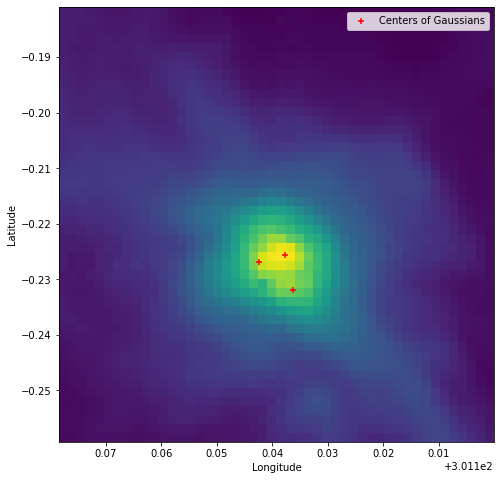

In [9]:
FWHM_vals = np.array([[18.,16.],
                 [12.,24.],
                 [22.,22.]])

mu_vals = np.array([[301.14,-0.227],
                    [301.14,-0.23],
                    [301.138,-0.225]])

theta_vals = np.array([0.,90.,0.])

n = 3

params,image = fitter(grid,data,sat,peaks=n,mu = mu_vals,
                      theta = theta_vals,FWHM=FWHM_vals)

plt.figure(figsize=(8,8))
plt.imshow(np.log10(image),origin='lower',extent=(X.max(),X.min(),Y.min(),Y.max()))
plt.scatter(params[0::6],params[1::6],marker='+',color='r',label='Centers of Gaussians')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

From the previous examples we can notice the initial parameters we give aren't exactly the ones that come out. This happens because the function changes them in order to find the best fit for the data. If the given parameters are certain, or have a known uncertainty this information can be inputted into the function, via the arguments $\tt{var_{---}pos,var_{---}theta,var_{---}FWHM}$ that take a float. These values are, if not stated otherwise, $0.01$ (in arcsec), $0.5$ (in degrees) and $0.5$ (in arcsec).

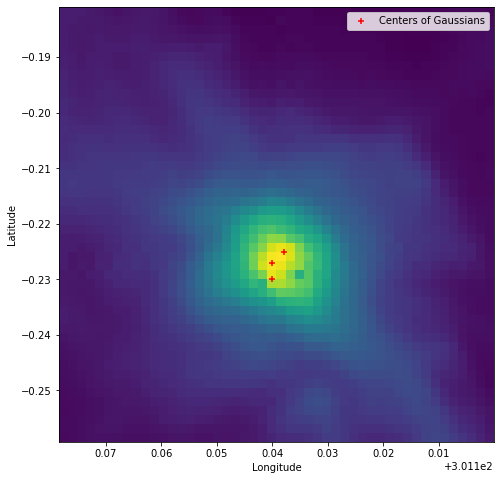

In [10]:
#Input the position, angle and FWHM
#practically restricting the FWHM and position, giving theta some freedom

FWHM_vals = np.array([[18.,16.],
                 [12.,24.],
                 [22.,22.]])

mu_vals = np.array([[0.04+3.011e2,-0.227],
                    [0.04+3.011e2,-0.23],
                    [0.038+3.011e2,-0.225]])

theta_vals = np.array([0.,90.,0.])

n = 3

params,image = fitter(grid,data,sat,peaks=n,mu = mu_vals,
                      theta = theta_vals,FWHM=FWHM_vals,
                     var_pos = 0.00001, var_theta = 90, var_FWHM = 0.00001)

plt.figure(figsize=(8,8))
plt.imshow(np.log10(image),origin='lower',extent=(X.max(),X.min(),Y.min(),Y.max()))
plt.scatter(params[0::6],params[1::6],marker='+',color='r',label='Centers of Gaussians')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

When inputting the positions of peaks, these can be viewed on top of the file image by plotting the data and overlaying the peaks' position using a scatter.

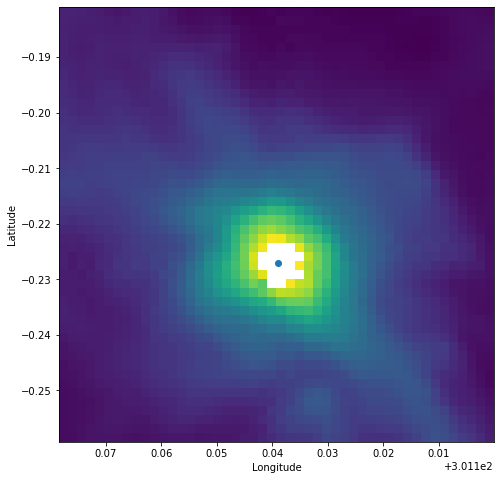

In [11]:
#Checking a peak in position 0.039+3.011e2, -0.227

X,Y = grid

plt.figure(figsize=(8,8))
plt.imshow(np.log10(data),origin='lower',extent=(X.max(),X.min(),Y.min(),Y.max()))
plt.scatter(0.039+3.011e2,-0.227) #checking this points location on the image
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Fitting Background Flux

For more complicted data, where the saturated area is surrounded by irregular flux, the $\tt{fitter}$ function has an argument that allows it to fit the surrounding non-saturated data by detecting local maxima (bumps in the flux) and placing a peak in that position. 
These peaks may not correspond to actual sources of flux, such as stars, they exist for the $\tt{fitter}$ to justify irregularities in the flux and account for the influence these "bumps" have, ultimately helping the function find and converge to a final result. You can enable background fitting by setting the argument $\tt{bg_{---}fitting = True}$.

The resulting array of parameters will contain the main peaks we wish to fit, followed by the background peaks found by the function.

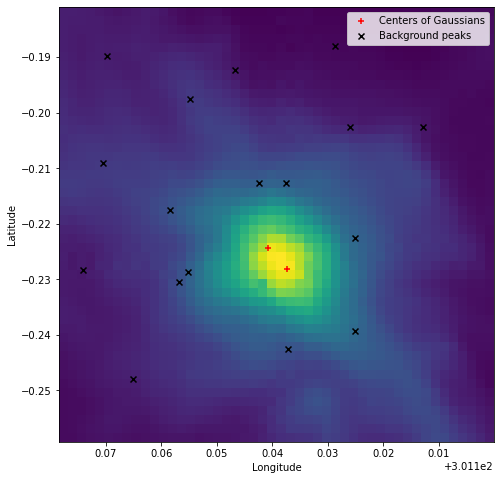

Main peak parameters: 
[ 3.01137413e+02 -2.28230553e-01  5.58595652e+04 -2.88733058e+00
  7.77778056e-03  7.77778056e-03]
[ 3.01140759e+02 -2.24396666e-01  3.73350508e+04 -2.41207081e+00
  6.11111389e-03  6.11111389e-03]

Background peaks parameters: 
[ 3.01137107e+02 -2.42607354e-01  1.69988492e+03 -2.84814980e+00
  1.38888889e-02  1.38888889e-02  3.01125116e+02 -2.39274020e-01
  1.63014700e+03 -2.54562416e+00  1.38888889e-02  1.38888889e-02
  3.01165116e+02 -2.48027331e-01  7.07488881e+02 -3.14097969e+00
  1.38888889e-02  1.38888889e-02  3.01156783e+02 -2.30537732e-01
  9.49387395e+02 -2.78019019e+00  1.38888889e-02  1.38888889e-02
  3.01174093e+02 -2.28300199e-01  7.04739196e+02 -3.12405085e+00
  1.38888856e-02  1.38888889e-02  3.01158450e+02 -2.17607446e-01
  9.57748319e+02 -2.80457110e+00  1.38888889e-02  1.38888889e-02
  3.01155116e+02 -2.28750237e-01  1.03997375e+03  2.78387552e+00
  1.38888889e-02  1.38888889e-02  3.01170496e+02 -2.09137566e-01
  1.15440421e+03 -2.36791414e+00 

In [12]:
#Fitting 2 peaks and background

FWHM_vals = np.array([[28.,28.],
                     [22,22]])

n = 2

params,image = fitter(grid,data,sat,peaks = n,
                      FWHM=FWHM_vals, bg_fitting = True, var_FWHM = 0.00001)

plt.figure(figsize=(8,8))
plt.imshow(np.log10(image),origin='lower',extent=(X.max(),X.min(),Y.min(),Y.max()))
plt.scatter(params[0::6][:n],params[1::6][:n],marker='+',color='r',label='Centers of Gaussians')
plt.scatter(params[0::6][n:],params[1::6][n:],marker="x",color="black",label="Background peaks")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

print("Main peak parameters: \n{i1}\n{i2}\n".format(i1 = params[:6*1], i2 = params[6:6*2]))

print("Background peaks parameters: \n{i}\n".format(i = params[6*n:]))

## All-in-one display & fitter

The function $\tt{file_{---}fitter}$ is the first step towards automation. It takes the file name and the FWHM value (assumed the same for both axis) and requests a series of inputs from the user: cutout  limits, number of source to fit and var_FWHM. The function combines the $\tt{display_{---}fits}$ and $\tt{fitter}$ and outputs the parameters, the corrected image and a graph of the fitted  gaussian curve alongside the flux data, centered in the middle of the saturated area.

Using the $\tt{file_{---}fitter}$ there is less control over other variables such as position and angle of the peak, which left to the freedom of the function. The FWHM is also assumed to be the same for every peak generated, including the background (which is always set to $\tt{True}$ even though those peaks are not plotted in the image below).

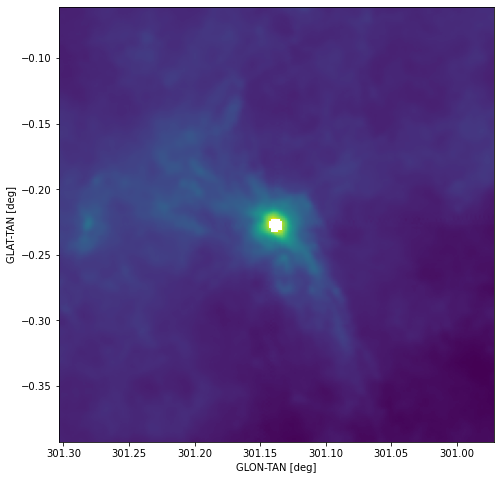

left 301.18
right 301.1
bottom -0.26
top -0.18


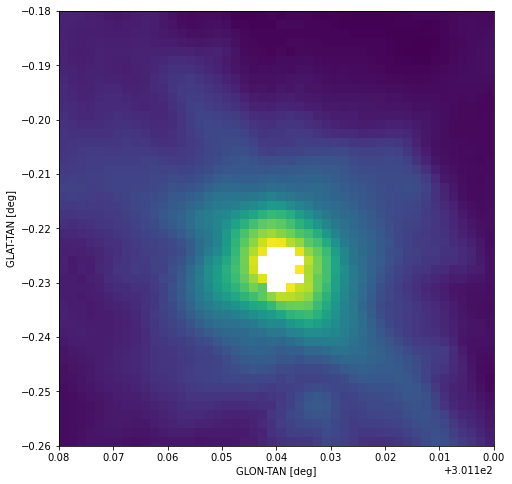

sources 1
FWHM flexible (0.5 -> default arcsec)? 0.5


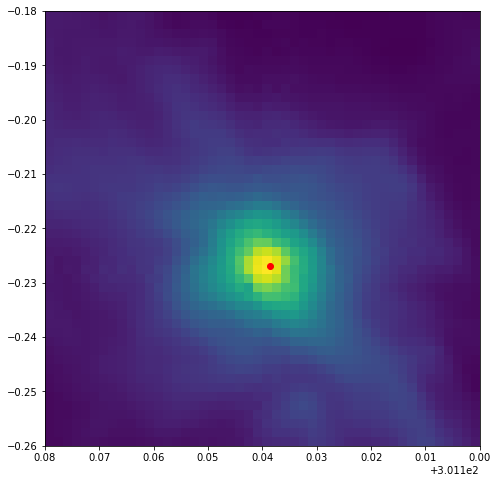

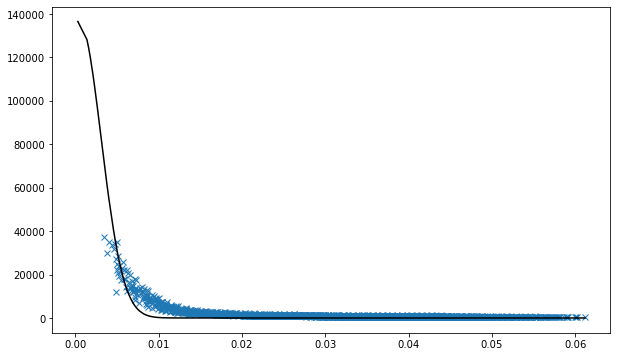

In [13]:
#Fitting 2 peaks and background

file = 'example.fits'

params,image = file_fitter(file,22)

## General Sheet

### Functions:

$\tt{display_{---}fits(file, lims, return_{---}vals = False)}$

- $\tt{file}$ - name of the file as a $\tt{str}$;
- $\tt{limits} = [left,right,bottom,upper]$ - list or array with borders of the desired sub-image;
- $\tt{return_{---}vals = True}$ - returns grid, subdata and saturated area.  

Plots the .fits file provided.

$-----------------------$

$\tt{fitter(grid,data,sat,peaks=1,mu=[\;],theta=[\;],FWHM=[\;],}$\
$\;\;\;\;\;\;\;\;\;\;\;\tt{bg_{---}fitting=False,units_{---}theta='deg',units_{---}FWHM='arcsec',}$\
$\;\;\;\;\;\;\;\;\;\;\;\tt{var_{---}pos=0.01,var_{---}theta=0.5,var_{---}FWHM=0.5)}$

- $\tt{grid}$ $\;\;$-$\;\;$ arrays containing values of longitude and latitude;
- $\tt{data}$ $\;\;$-$\;\;$ 2x2 matrix extracted from .fits file;
- $\tt{sat}$ $\;\;$-$\;\;$ Boolean array specifying which points are saturated;
- $\tt{peaks}$ $\;\;$-$\;\;$ int specifying number of peaks to fit in the saturated area;
- $\tt{mu}$ (optional) $\;\;$-$\;\;$ array containing pairs of values specifying the position of the peaks;
- $\tt{theta}$ (optional) $\;\;$-$\;\;$ array containing the angle between the semi major axis and the longitude;
- $\tt{FWHM}$ (optional) $\;\;$-$\;\;$ arrays containing pairs of values specifying the FWHM on the x and y axis;
- $\tt{bg_{---}fitting = True}$ (optional) $\;\;$-$\;\;$ Enables the function to fit the background maxima;
- $\tt{units_{---}theta}$ (optional) $\;\;$-$\;\;$ string object to change input of theta from degrees to arcsec;
- $\tt{units_{---}FWHM}$ (optional) $\;\;$-$\;\;$ string object to change input of FWHM from arcsec to degrees;
- $\tt{var_{---}pos}$ (optional) $\;\;$-$\;\;$ float indicating the tolerance for position variation, only use if $\tt{mu}$ is specified;
- $\tt{var_{---}theta}$ (optional) $\;\;$-$\;\;$ float indicating the tolerance for angle variation, only use if $\tt{theta}$ is specified;
- $\tt{var_{---}FWHM}$ (optional) $\;\;$-$\;\;$ float indicating the tolerance for FWHM variation, only use if $\tt{FWHM}$ is specified;

Returns parameters of the fitted gaussians and the corrected data image.

$-----------------------$

$\tt{file_{---}fitter(file,FWHMval)}$

- $\tt{file}$ - name of file as a $\tt{str}$;
- $\tt{FWHMval}$ - Single value of FWHM for all peaks in arcsec.
- Inputs:
 - list or array with borders of the desired sub-image;
 - int number of peaks to fit;
 - float specifying FWHM tolerance
 
Returns parameters of the fitted gaussians and the corrected data image.
